In [39]:
import gnssvod as gv
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.dates as mdates

# set which data files should be loaded
pattern = 'data_RINEX3.03/Laeg_paired/nc/*.nc'
# define how to associate stations together. Always put reference station first.
pairings = {'Laeg':('CH-Laeg_ref','CH-Laeg_grn')}
# define if some observables with similar frequencies should be combined together. In the future, this should be replaced by the selection of frequency bands.
bands = {'VOD1':['S1','S1X','S1C'],'VOD7':['S7','S7X','S7C']}

vod = gv.calc_vod(pattern,pairings,bands)
vod = vod['Laeg']

# intialize hemispheric grid
hemi = gv.hemibuild(2)
# get patches for plotting later
patches = hemi.patches()
# classify vod into grid cells, drop azimuth and elevation afterwards as we don't need it anymore
vod = hemi.add_CellID(vod).drop(columns=['Azimuth','Elevation'])
vod

/home/konsch/Documents/5-Repos/gnssvod/gnssvod/hemistats/hemistats.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  idf=idf.groupby('eleind',group_keys=False).apply(azicut) # groupby will drop rows with eleind=NaN
/home/konsch/Documents/5-Repos/gnssvod/gnssvod/hemistats/hemistats.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  iele = idf.eleind[0]
/home/konsch/Documents/5-Repos/gnssvod/gnssvod/hemistats/hemistats.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acc

VOD1  VOD7  CellID
Epoch               SV                         
2023-08-01 00:07:45 C19       NaN   NaN    3733
                    C20       NaN   NaN    5444
                    C23       NaN   NaN    6052
                    C27       NaN   NaN    3267
                    C28       NaN   NaN    2130
...                           ...   ...     ...
2023-08-09 23:59:45 R04  1.116509   NaN    3128
                    R12  0.274069   NaN    6048
                    R13  2.020736   NaN    1795
                    R14  2.327782   NaN    1044
                    R24 -0.010382   NaN    3668

[1329259 rows x 3 columns]

In [40]:
# get average value per grid cell
vod_avg = vod.groupby(['CellID']).agg(['mean', 'std', 'count'])
# flatten the columns
vod_avg.columns = ["_".join(x) for x in vod_avg.columns.to_flat_index()]
vod_avg.reset_index()

,CellID,VOD1_mean,VOD1_std,VOD1_count,VOD7_mean,VOD7_std,VOD7_count
0,0,0.879183,0.507725,184,1.810452,0.509661,57
1,1,0.757022,0.561797,374,1.330002,0.449482,120
2,2,0.572596,0.531027,158,2.221168,0.778867,70
3,3,2.128975,1.155671,58,1.266589,0.548697,58
4,4,0.834365,0.637610,39,0.907239,0.424226,39
...,...,...,...,...,...,...,...
5119,6420,0.020885,0.019975,26,0.034187,0.015323,26
5120,6431,1.572118,1.512187,37,NaN,NaN,0
5121,6432,0.086603,0.033302,18,NaN,NaN,0
5122,6438,0.070679,0.056207,32,NaN,NaN,0


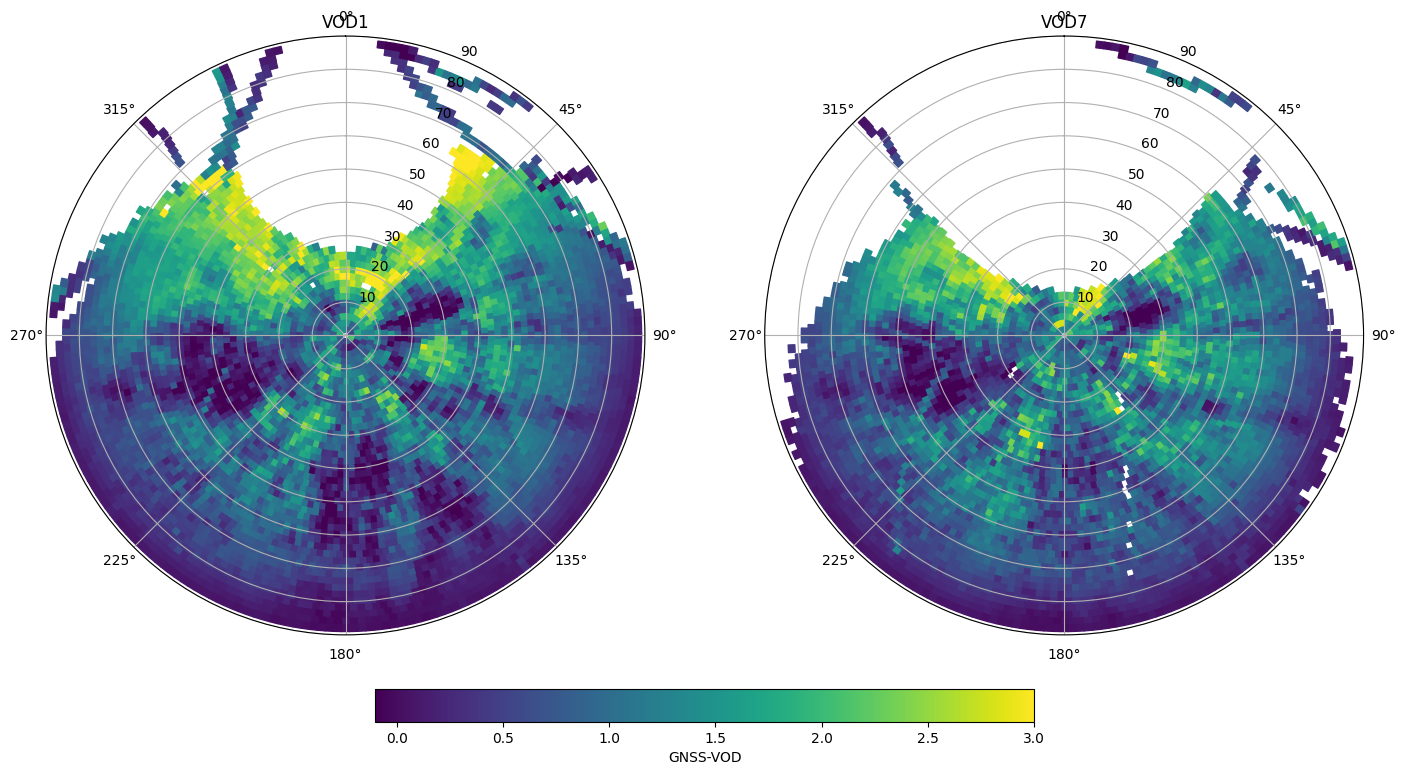

In [41]:
fig, ax = plt.subplots(1,2,figsize=(17,14),subplot_kw=dict(projection='polar'))

vod_names = ['VOD1','VOD7']
for i, iname in enumerate(vod_names):
    # associate the mean values to the patches, join inner will drop patches with no data, making plotting slightly faster
    ipatches = pd.concat([patches,vod_avg[f"{iname}_mean"]],join='inner',axis=1)
    # plotting with colored patches
    pc = PatchCollection(ipatches.Patches,array=ipatches[f"{iname}_mean"],edgecolor='face', linewidth=1)
    pc.set_clim([-0.1,3])
    ax[i].add_collection(pc)
    ax[i].set_rlim([0,90])
    ax[i].set_theta_zero_location("N")
    ax[i].set_theta_direction(-1)
    ax[i].set_title(iname)

plt.colorbar(pc, ax=ax, location='bottom', shrink=.5, pad=0.05, label='GNSS-VOD')

## Creation of Time Series

Devation from Humphrey approach: Per satellite normalization. Therefore do-calc the VOD average per satellite and subtract it from the VOD values. This will give us the VOD anomaly per satellite.

In [42]:
vod_avg = vod.groupby(['CellID','SV']).agg(['mean', 'std', 'count'])
# flatten the columns
vod_avg.columns = ["_".join(x) for x in vod_avg.columns.to_flat_index()]
vod_avg

VOD1_mean  VOD1_std  VOD1_count  VOD7_mean  VOD7_std  VOD7_count
CellID SV                                                                   
0      C24        NaN       NaN           0        NaN       NaN           0
       C25        NaN       NaN           0        NaN       NaN           0
       C28        NaN       NaN           0        NaN       NaN           0
       C33        NaN       NaN           0        NaN       NaN           0
       E02   1.140866  0.889004          20   1.482793  0.331701          20
...               ...       ...         ...        ...       ...         ...
6431   R07   0.149809  0.050292          19        NaN       NaN           0
6432   R01   0.086603  0.033302          18        NaN       NaN           0
6438   R01   0.131612  0.037028          12        NaN       NaN           0
       R02   0.034119  0.024675          20        NaN       NaN           0
6439   R01   0.039912  0.015835           8        NaN       NaN           0

[63080 rows x 6 columns]

In [43]:
# merge statistics with the original VOD measurements

vod_anom = vod.join(vod_avg,on=['CellID', 'SV'])
vod_anom['VOD1_anom'] = vod_anom['VOD1']-vod_anom['VOD1_mean']
vod_anom['VOD7_anom'] = vod_anom['VOD7']-vod_anom['VOD7_mean']
vod_anom

VOD1  VOD7  CellID  VOD1_mean  VOD1_std  \
Epoch               SV                                                 
2023-08-01 00:07:45 C19       NaN   NaN    3733        NaN       NaN   
                    C20       NaN   NaN    5444        NaN       NaN   
                    C23       NaN   NaN    6052        NaN       NaN   
                    C27       NaN   NaN    3267        NaN       NaN   
                    C28       NaN   NaN    2130        NaN       NaN   
...                           ...   ...     ...        ...       ...   
2023-08-09 23:59:45 R04  1.116509   NaN    3128   0.907967  0.506974   
                    R12  0.274069   NaN    6048   0.323400  0.081283   
                    R13  2.020736   NaN    1795   1.814035  0.729156   
                    R14  2.327782   NaN    1044   2.496951  0.794480   
                    R24 -0.010382   NaN    3668   0.077350  0.182376   

                         VOD1_count  VOD7_mean  VOD7_std  VOD7_count  \
Epoch               SV                                                 
2023-08-01 00:07:45 C19           0        NaN       NaN           0   
                    C20           0        NaN       NaN           0   
                    C23           0        NaN       NaN           0   
                    C27           0        NaN       NaN           0   
                    C28           0        NaN       NaN           0   
...                             ...        ...       ...         ...   
2023-08-09 23:59:45 R04          19        NaN       NaN           0   
                    R12          25        NaN       NaN           0   
                    R13          28        NaN       NaN           0   
                    R14          30        NaN       NaN           0   
                    R24          30        NaN       NaN           0   

                         VOD1_anom  VOD7_anom  
Epoch               SV                         
2023-08-01 00:07:45 C19        NaN        NaN  
                    C20        NaN        NaN  
                    C23        NaN        NaN  
                    C27        NaN        NaN  
                    C28        NaN        NaN  
...                            ...        ...  
2023-08-09 23:59:45 R04   0.208542        NaN  
                    R12  -0.049331        NaN  
                    R13   0.206701        NaN  
                    R14  -0.169169        NaN  
                    R24  -0.087732        NaN  

[1329259 rows x 11 columns]

In [44]:
vod_ts = vod_anom.groupby(pd.Grouper(freq='30min', level='Epoch')).mean()
vod_ts['VOD1_anom'] = vod_ts['VOD1_anom']+vod_ts['VOD1'].mean()
vod_ts['VOD7_anom'] = vod_ts['VOD7_anom']+vod_ts['VOD7'].mean()
vod_ts


,VOD1,VOD7,CellID,VOD1_mean,VOD1_std,VOD1_count,VOD7_mean,VOD7_std,VOD7_count,VOD1_anom,VOD7_anom
Epoch,,,,,,,,,,,
2023-08-01 00:00:00,1.037329,1.237644,3298.125477,1.054438,0.331780,40.344214,1.212377,0.383523,2.726155,1.034356,1.092845
2023-08-01 00:30:00,1.052796,0.622201,3046.429437,1.065347,0.405122,46.751604,0.652777,0.279440,3.895937,1.036399,1.073783
2023-08-01 01:00:00,1.112414,0.959862,3112.844579,1.124431,0.402333,45.085935,0.876000,0.276608,3.097684,1.041050,1.096248
2023-08-01 01:30:00,1.083810,0.865218,3137.215262,1.107362,0.367769,48.792687,0.884802,0.272065,4.295707,1.022910,1.063558
2023-08-01 02:00:00,1.072477,1.113385,3188.493254,1.073408,0.375396,48.891120,1.151861,0.333010,5.064010,1.047320,1.089433
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-09 21:30:00,1.125427,1.163597,2605.828425,1.144556,0.475945,37.637671,1.222209,0.381383,3.373630,1.027409,1.079499
2023-08-09 22:00:00,0.966381,1.119022,2817.523092,0.972460,0.467289,38.474984,1.115268,0.427961,4.328416,1.040353,1.087347
2023-08-09 22:30:00,0.917218,0.741063,3065.459119,0.888955,0.402207,36.372866,0.705950,0.297992,3.525007,1.068769,1.083685


Plot the time series

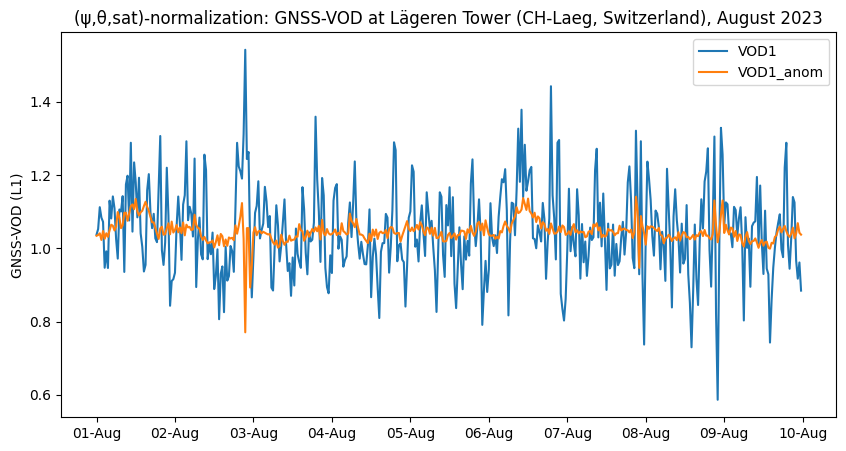

In [45]:
vod_names = ['VOD1', 'VOD1_anom']

fig, ax = plt.subplots(1, figsize=(10, 5))
for i, iname in enumerate(vod_names):
    # plot each measurement and color by signal to noise ratio
    hs = ax.plot(vod_ts.index.get_level_values('Epoch'), vod_ts[iname], label=iname)

myFmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('GNSS-VOD (L1)')
ax.legend()
plt.title('(ψ,θ,sat)-normalization: GNSS-VOD at Lägeren Tower (CH-Laeg, Switzerland), August 2023')
plt.savefig('figures/illustration_vod.png', facecolor='white', transparent=False, bbox_inches='tight')

### Humphrey Approach (copied from 04 demo)

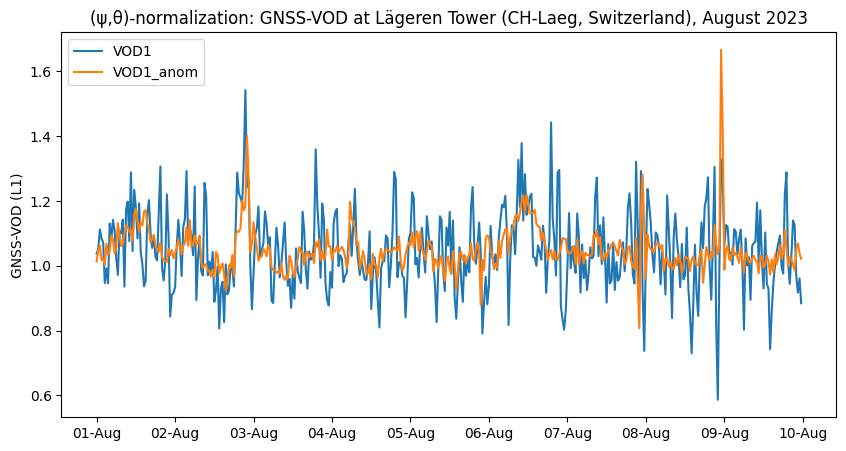

In [46]:
# get average value per grid cell
vod_avg = vod.groupby(['CellID']).agg(['mean', 'std', 'count'])
# flatten the columns
vod_avg.columns = ["_".join(x) for x in vod_avg.columns.to_flat_index()]
vod_avg.reset_index()

vod_anom = vod.join(vod_avg,on='CellID')
vod_anom['VOD1_anom'] = vod_anom['VOD1']-vod_anom['VOD1_mean']
vod_anom['VOD7_anom'] = vod_anom['VOD7']-vod_anom['VOD7_mean']
vod_ts = vod_anom.groupby(pd.Grouper(freq='30min', level='Epoch')).mean()
vod_ts['VOD1_anom'] = vod_ts['VOD1_anom']+vod_ts['VOD1'].mean()
vod_ts['VOD7_anom'] = vod_ts['VOD7_anom']+vod_ts['VOD7'].mean()

vod_names = ['VOD1', 'VOD1_anom']

fig, ax = plt.subplots(1, figsize=(10, 5))
for i, iname in enumerate(vod_names):
    # plot each measurement and color by signal to noise ratio
    hs = ax.plot(vod_ts.index.get_level_values('Epoch'), vod_ts[iname], label=iname)

myFmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('GNSS-VOD (L1)')
ax.legend()
plt.title('(ψ,θ)-normalization: GNSS-VOD at Lägeren Tower (CH-Laeg, Switzerland), August 2023')
plt.savefig('figures/illustration_vod.png', facecolor='white', transparent=False, bbox_inches='tight')

In [38]:
## Make a tile plot representation of the two approaches